# Notebook to get started with the database
This notebook provides some basic helper functions to work with the EUBUCCO database.         

Author: Felix Wagner (wagner@mcc-berlin.net), Nikola Milojevic-Dupont    
Date: 08.05.2022 (updated: 19.10.2022)

In [2]:
# required modules
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# 0) Read the files

Use GeoPandas, it can even read zipped files without unzipping them!

In [4]:
path = 'v0_1-FRA_1_2_3_11_1-Vichy.gpkg.zip'

df = gpd.read_file(path) # if you have unzipped the file removed .zip
df

,id,height,age,type,id_source,type_source,geometry
0,v0.1-FRA.1.2.3.11_1-0,1.8,NaN,None,BATIMENT0000002201545772,Indifférencié,"POLYGON ((3813315.435 2578264.986, 3813320.501..."
1,v0.1-FRA.1.2.3.11_1-1,2.5,NaN,None,BATIMENT0000002201545773,Indifférencié,"POLYGON ((3813314.600 2578266.873, 3813312.160..."
2,v0.1-FRA.1.2.3.11_1-2,2.2,NaN,None,BATIMENT0000002201545774,Indifférencié,"POLYGON ((3813365.262 2578291.039, 3813360.612..."
3,v0.1-FRA.1.2.3.11_1-3,2.2,NaN,None,BATIMENT0000002201545775,Indifférencié,"POLYGON ((3813377.901 2578285.128, 3813362.431..."
4,v0.1-FRA.1.2.3.11_1-4,3.1,NaN,None,BATIMENT0000002201545776,Indifférencié,"POLYGON ((3813308.103 2578261.758, 3813306.462..."
...,...,...,...,...,...,...,...
11136,v0.1-FRA.1.2.3.11_1-11136,7.6,NaN,None,BATIMENT0000002201686916,Indifférencié,"POLYGON ((3813625.906 2579249.680, 3813622.280..."
11137,v0.1-FRA.1.2.3.11_1-11137,7.5,NaN,None,BATIMENT0000002201687402,Indifférencié,"POLYGON ((3813772.657 2579308.808, 3813772.840..."
11138,v0.1-FRA.1.2.3.11_1-11138,NaN,NaN,None,BATIMENT0000002201692642,Indifférencié,"POLYGON ((3813976.552 2578633.668, 3813975.783..."
11139,v0.1-FRA.1.2.3.11_1-11139,NaN,NaN,None,BATIMENT0000002201693396,Indifférencié,"POLYGON ((3814166.522 2578242.454, 3814157.767..."


<AxesSubplot:>

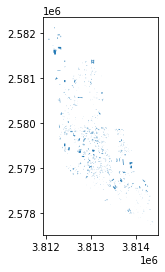

In [14]:
df.plot() # plots all the data from the file

<AxesSubplot:>

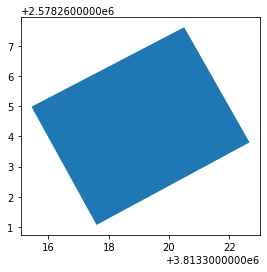

In [13]:
# plot a given row
df.iloc[[0]].plot()

## 1) How to work with large files and limited computational resources.
Instead of reading in a whole file at once, one can read in a file in chunks (of any size).

In [16]:
df = gpd.read_file(path, rows = 1000)
df.tail()

,id,height,age,type,id_source,type_source,geometry
995,v0.1-FRA.1.2.3.11_1-995,2.5,NaN,None,BATIMENT0000002201689056,Indifférencié,"POLYGON ((3813076.434 2578803.380, 3813077.836..."
996,v0.1-FRA.1.2.3.11_1-996,9.0,1900.0,non-residential,BATIMENT0000002201689058,Commercial et services,"POLYGON ((3813088.148 2578891.694, 3813097.014..."
997,v0.1-FRA.1.2.3.11_1-997,20.0,NaN,non-residential,BATIMENT0000002201688763,Commercial et services,"POLYGON ((3812548.377 2578945.916, 3812560.541..."
998,v0.1-FRA.1.2.3.11_1-998,21.7,1900.0,residential,BATIMENT0000002201688769,Résidentiel,"POLYGON ((3812621.572 2578861.264, 3812614.153..."
999,v0.1-FRA.1.2.3.11_1-999,13.8,NaN,None,BATIMENT0000002201688779,Indifférencié,"POLYGON ((3812648.147 2578905.983, 3812645.797..."


# 2) From GADM to individual buildings and vice versa: Adding country, region and city level information to the building level data.
If you want to find buildings only from a specific country, region or city, we recommend to use the table **admin-codes-matches-v0.1.csv** to filter for the country or region name and then choose the relevant dataset to download based on the id.   

In case you want to add the country, region and city names to the building level data, feel free to use the following function to match the admin-codes-matches-v0.1.csv table with the ids of your data.

In [7]:
def match_gadm_info(df_temp,df_overview):
    """ function to match country, region and city info from overview table with building level data
        df_temp (dataframe):=   building level dataframe
        df_overview:=           overview table
    """
    # remove numbering at end of id str 
    df_temp['id_temp'] = df_temp['id'].str.rsplit('-',1).apply(lambda x: x[0])
    # merge with overview file
    df_out = df.merge(df_overview, left_on='id_temp',right_on='id')
    # keep only relevant columns
    df_out = df_out[['id_x','id_source','country','region','city','height','age','type','type_source','geometry']]
    # rename back to 'id' and return
    return df_out.rename(columns={'idx_x':'id'})

In [10]:
# define path to overview file
path_overview_file = 'admin-codes-matches-v0.1.zip'

# read in overview file
df_overview = pd.read_csv(path_overview_file)

# check overview file
df_overview.head()

,id,country,region,city,source
0,v0.1-AUT.4.16.24_1,austria,Oberösterreich,Pilsbach,austria-osm
1,v0.1-AUT.3.15.42_1,austria,Niederösterreich,Wimpassing im Schwarzatale,austria-osm
2,v0.1-AUT.3.15.43_1,austria,Niederösterreich,Würflach,austria-osm
3,v0.1-AUT.3.15.44_1,austria,Niederösterreich,Zöbern,austria-osm
4,v0.1-AUT.3.17.1_1,austria,Niederösterreich,Sankt Pölten,austria-osm


In [17]:
# match gadm info to bldg lvl data and assign to df
df = match_gadm_info(df,df_overview)

# check df: we have some additional columns added now
df.head()

,id_x,id_source,country,region,city,height,age,type,type_source,geometry
0,v0.1-FRA.1.2.3.11_1-0,BATIMENT0000002201545772,france,Auvergne-Rhône-Alpes,Vichy,1.8,NaN,None,Indifférencié,"POLYGON ((3813315.435 2578264.986, 3813320.501..."
1,v0.1-FRA.1.2.3.11_1-1,BATIMENT0000002201545773,france,Auvergne-Rhône-Alpes,Vichy,2.5,NaN,None,Indifférencié,"POLYGON ((3813314.600 2578266.873, 3813312.160..."
2,v0.1-FRA.1.2.3.11_1-2,BATIMENT0000002201545774,france,Auvergne-Rhône-Alpes,Vichy,2.2,NaN,None,Indifférencié,"POLYGON ((3813365.262 2578291.039, 3813360.612..."
3,v0.1-FRA.1.2.3.11_1-3,BATIMENT0000002201545775,france,Auvergne-Rhône-Alpes,Vichy,2.2,NaN,None,Indifférencié,"POLYGON ((3813377.901 2578285.128, 3813362.431..."
4,v0.1-FRA.1.2.3.11_1-4,BATIMENT0000002201545776,france,Auvergne-Rhône-Alpes,Vichy,3.1,NaN,None,Indifférencié,"POLYGON ((3813308.103 2578261.758, 3813306.462..."
